In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

In [2]:
# Load the image
image_path = "../data/images/ngc2403.png"
#resembling human eye perception
#image_data = np.dot(plt.imread(image_path)[..., :3], [0.2989, 0.5870, 0.1140])
image_data = np.dot(plt.imread(image_path)[..., :3], [1,1,1])

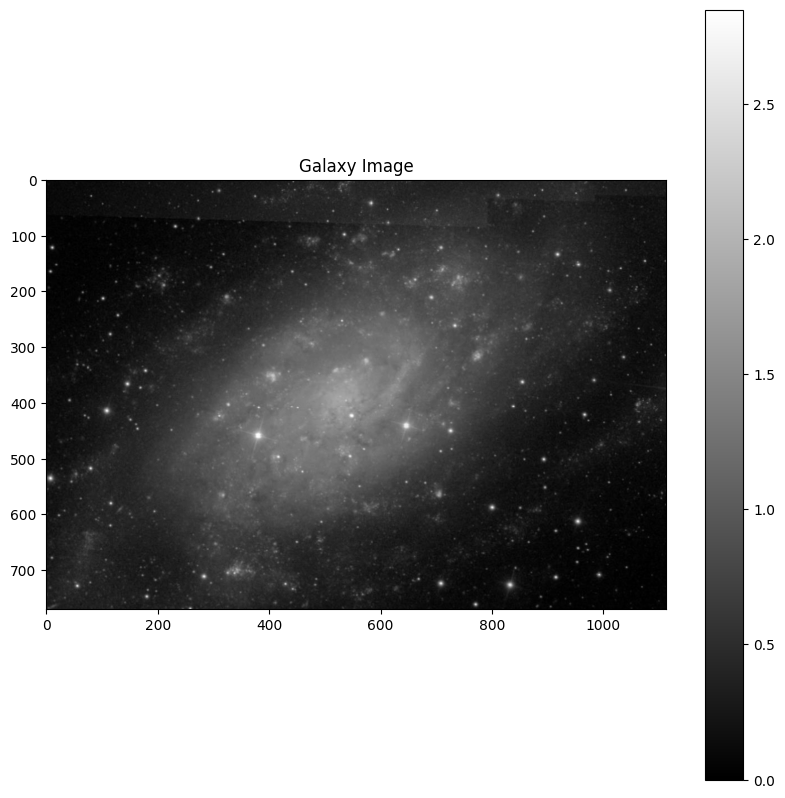

In [17]:
# Display the image using a logarithmic scale for better visualization
plt.figure(figsize=(10, 10))
#plt.imshow(image_data, norm=LogNorm(), cmap='gray')
plt.imshow(image_data, cmap='gray')
plt.colorbar()
plt.title('Galaxy Image')
plt.show()


Refined center coordinates: x=531.3202648197789, y=422.7708751017601


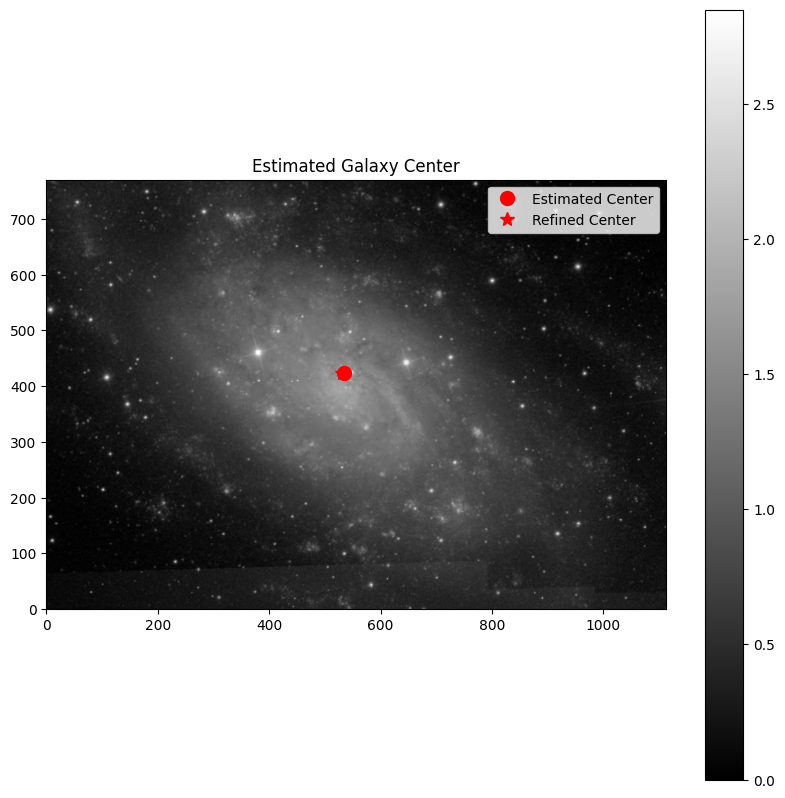

Estimated center coordinates: x=534, y=424


In [18]:
from photutils.centroids import centroid_com

# Sum intensities along x and y axes
sum_x = np.sum(image_data, axis=0)
sum_y = np.sum(image_data, axis=1)

# Find the peak in the marginal sums
center_x = np.argmax(sum_x)
center_y = np.argmax(sum_y)


# Define a small box around the approximate center to refine the centroid calculation
box_size = 50  # Adjust based on the image scale
x_min, x_max = max(0, center_x - box_size), min(image_data.shape[1], center_x + box_size)
y_min, y_max = max(0, center_y - box_size), min(image_data.shape[0], center_y + box_size)

sub_image = image_data[y_min:y_max, x_min:x_max]

# Calculate the centroid
centroid_y, centroid_x = centroid_com(sub_image)

# Adjust centroid relative to the full image
refined_center_x = x_min + centroid_x
refined_center_y = y_min + centroid_y


# Display the center location
plt.figure(figsize=(10, 10))
plt.imshow(image_data, cmap='gray', origin='lower')
plt.plot(center_x, center_y, 'ro', markersize=10, label='Estimated Center')
plt.plot(refined_center_x, refined_center_y, 'r*', markersize=10, label='Refined Center')
print(f"Refined center coordinates: x={refined_center_x}, y={refined_center_y}")
plt.legend()
plt.colorbar()
plt.title('Estimated Galaxy Center')
plt.show()

print(f"Estimated center coordinates: x={center_x}, y={center_y}")


In [7]:
import numpy as np
from photutils.isophote import Ellipse, EllipseGeometry

# Define the geometry starting at the refined center
geometry = EllipseGeometry(
    x0=refined_center_x, y0=refined_center_y, sma=200, eps=0.2, pa=np.deg2rad(135)
)  # sma is the semi-major axis

# Build an ellipse using the image data
ellipse = Ellipse(image_data, geometry)

# Fit the isophotes to the image data
isolist = ellipse.fit_image()

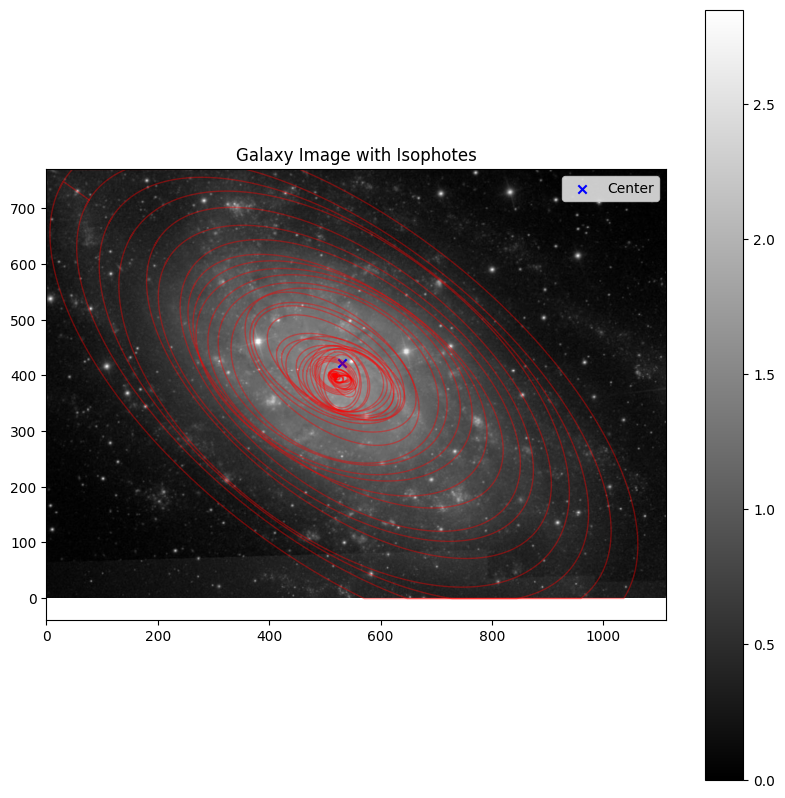

In [19]:
# Plot the image with fitted isophotes
plt.figure(figsize=(10, 10))
plt.imshow(image_data, cmap='gray', origin='lower')
plt.colorbar()
plt.title('Galaxy Image with Isophotes')

# Overlay isophotes
incs = []
for j, iso in enumerate(isolist):
    if j!=0:
        a = iso.sma #semieje mayor
        b = iso.sma * (1 - iso.eps)
        incs.append(
            np.degrees(
                np.arccos(
                    b/a
                )
            )
        )
        
    x, y = iso.sampled_coordinates()
    plt.plot(x, y, color='red', lw=1.0, alpha=0.4)

plt.scatter(refined_center_x, refined_center_y, color='blue', marker='x', label='Center')
plt.legend()
plt.show()

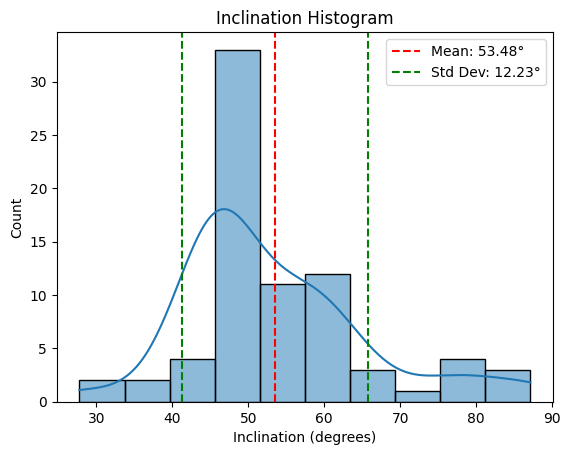

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

mean_inclination = np.mean(incs)
std_inclination = np.std(incs)

sns.histplot(incs, kde=True, bins=10)
plt.title('Inclination Histogram')
plt.xlabel('Inclination (degrees)')
plt.ylabel('Count')

plt.axvline(mean_inclination, color='r', linestyle='--', label=f'Mean: {mean_inclination:.2f}°')
plt.axvline(mean_inclination + std_inclination, color='g', linestyle='--', label=f'Std Dev: {std_inclination:.2f}°')
plt.axvline(mean_inclination - std_inclination, color='g', linestyle='--')

plt.legend()
plt.show()

/tmp/ipykernel_31510/3442360290.py:16: RuntimeWarning: invalid value encountered in log10
  surface_brightness = -2.5 * np.log10(np.array(mean_intensity) - median) + 22.5


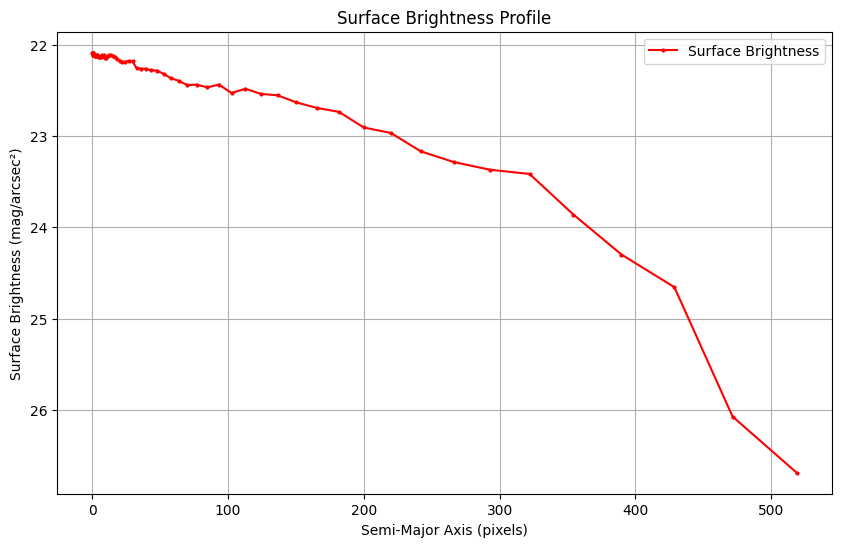

In [46]:
from astropy.stats import sigma_clipped_stats

# Calculate the background statistics
mean, median, stddev = sigma_clipped_stats(image_data)

# Extract radius (sma) and mean intensity from each isophote
radii = []
mean_intensity = []

for iso in isolist:
    radii.append(iso.sma)  # Semi-major axis of the isophote
    mean_intensity.append(iso.intens)

# Convert mean intensity to surface brightness in magnitude scale, subtracting the median background
# Using a simple conversion: mag = -2.5 * log10(intensity)
surface_brightness = -2.5 * np.log10(np.array(mean_intensity) - median) + 22.5

# Plot the surface brightness profile
plt.figure(figsize=(10, 6))
plt.plot(radii, surface_brightness, '-o', color='red', label='Surface Brightness', markersize=2)
plt.gca().invert_yaxis()  # Magnitude decreases as brightness increases
plt.xlabel('Semi-Major Axis (pixels)')
plt.ylabel('Surface Brightness (mag/arcsec²)')
plt.title('Surface Brightness Profile')
plt.grid(True)
plt.legend()
plt.show()

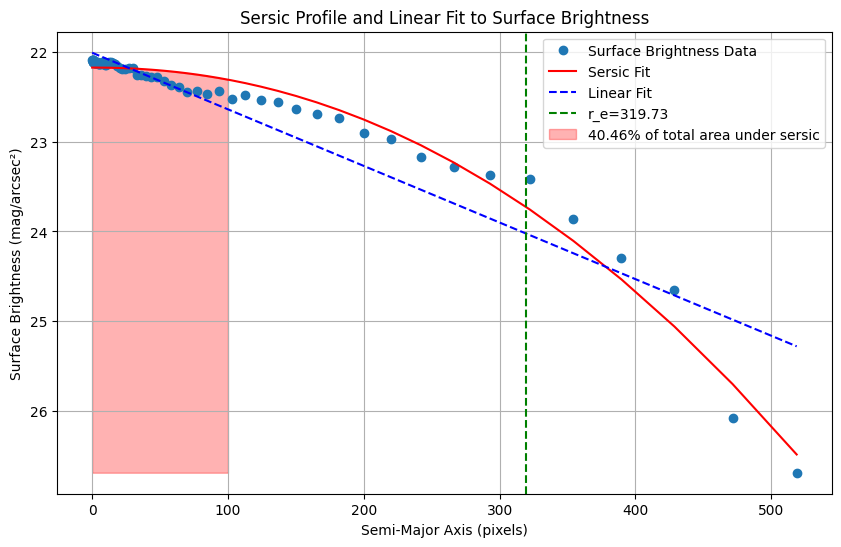

Fitted Sersic Parameters: mu_e=23.73 mag/arcsec², r_e=319.73 pixels, n=0.47
Fitted Linear Parameters: a=0.01, b=22.01
Area under Sersic (0-100): 0.00
Total area under Sersic: 0.00
Percentage of area (0-100): 40.46%


In [136]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Define the Sersic profile in surface brightness
def sersic_surface_brightness(r, mu_e, r_e, n):
    b_n = 2 * n - 0.327
    return mu_e + 2.5 * b_n * ((r / r_e)**(1/n) - 1)

# Define a linear function
def linear_surface_brightness(r, a, b):
    return a * r + b

# Remove NaNs from the data
non_nan_radii = np.array(radii)[~np.isnan(surface_brightness)]
non_nan_surface_brightness = surface_brightness[~np.isnan(surface_brightness)]

# Fit the Sersic profile to the surface brightness data
popt_sersic, pcov_sersic = curve_fit(sersic_surface_brightness, non_nan_radii, non_nan_surface_brightness, p0=[20, 10, 2])
mu_e, r_e, n = popt_sersic

# Fit the linear function to the surface brightness data
popt_linear, pcov_linear = curve_fit(linear_surface_brightness, non_nan_radii, non_nan_surface_brightness)
a, b = popt_linear

# Define the Sersic profile function for integration
def sersic_intensity(r):
    return 10 ** (-0.4 * sersic_surface_brightness(r, mu_e, r_e, n))

# Calculate the total area under the Sersic curve from 0 to max radius
total_area, _ = quad(sersic_intensity, 0, max(non_nan_radii))

# Calculate the area under the Sersic curve from 0 to 100
area_0_100, _ = quad(sersic_intensity, 0, 100)

# Calculate the percentage of area between x = 0 and x = 100
percentage_area_0_100 = (area_0_100 / total_area) * 100

# Plot the data, the fitted Sersic profile, and the linear fit
plt.figure(figsize=(10, 6))
plt.plot(radii, surface_brightness, 'o', label='Surface Brightness Data')
plt.plot(radii, sersic_surface_brightness(np.array(radii), *popt_sersic), '-', color='red', label='Sersic Fit')
plt.plot(radii, linear_surface_brightness(np.array(radii), *popt_linear), '--', color='blue', label='Linear Fit')
plt.axvline(r_e, color='green', linestyle='--', label=f'r_e={r_e:.2f}')

# Fill the area under the Sersic curve from x=0 to x=100
r_vals = np.linspace(0, 100, 500)
plt.fill_between(x=r_vals, y1= [max(non_nan_surface_brightness)]*len(r_vals), y2=sersic_surface_brightness(r_vals, mu_e, r_e, n), color='red', alpha=0.3, label=f'{percentage_area_0_100:.2f}% of total area under sersic')


plt.gca().invert_yaxis()  # Magnitude scale, lower values mean brighter
plt.xlabel('Semi-Major Axis (pixels)')
plt.ylabel('Surface Brightness (mag/arcsec²)')
plt.title('Sersic Profile and Linear Fit to Surface Brightness')
plt.grid(True)
plt.legend()
plt.show()

print(f"Fitted Sersic Parameters: mu_e={mu_e:.2f} mag/arcsec², r_e={r_e:.2f} pixels, n={n:.2f}")
print(f"Fitted Linear Parameters: a={a:.2f}, b={b:.2f}")
print(f"Area under Sersic (0-100): {area_0_100:.2f}")
print(f"Total area under Sersic: {total_area:.2f}")
print(f"Percentage of area (0-100): {percentage_area_0_100:.2f}%")


## Pitch angle

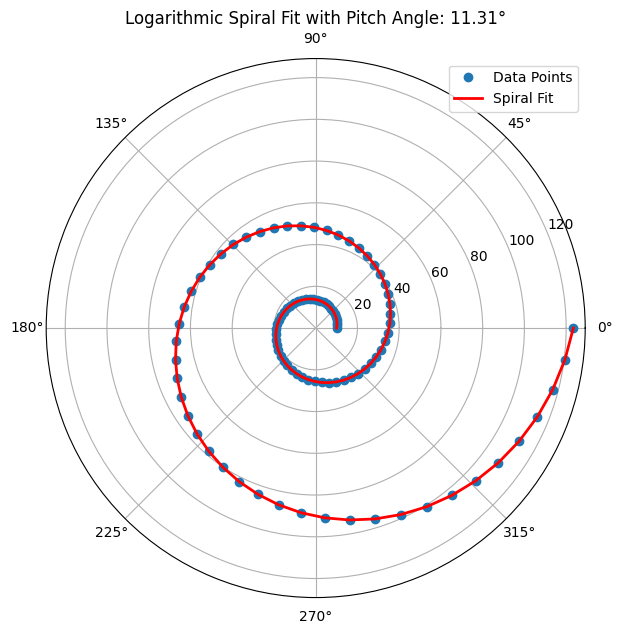

Estimated Pitch Angle: 11.31°


In [144]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage import io, filters
import cv2

# Load the image
image_path = '../data/images/ngc2403.png'
image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Edge detection
edges = filters.sobel(gray_image)

# Define the logarithmic spiral function
def log_spiral(theta, a, b):
    return a * np.exp(b * theta)

# Example coordinates of a spiral arm (to be replaced by actual coordinates)
theta = np.linspace(0, 4 * np.pi, 100)  # Angular positions (in radians)
r = log_spiral(theta, 10, 0.2)  # Radial distances for demo

# Fit the logarithmic spiral model
params, _ = curve_fit(log_spiral, theta, r)
a_fit, b_fit = params

# Calculate the pitch angle
pitch_angle = np.degrees(np.arctan(b_fit))

# Generate the fitted spiral
theta_fit = np.linspace(0, 4 * np.pi, 100)
r_fit = log_spiral(theta_fit, *params)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': 'polar'})

# Plot the original data points in polar coordinates
ax.plot(theta, r, 'o', label='Data Points')

# Plot the fitted logarithmic spiral in polar coordinates
ax.plot(theta_fit, r_fit, '-', color='red', linewidth=2, label='Spiral Fit')

# Set plot title and add legend
ax.set_title(f"Logarithmic Spiral Fit with Pitch Angle: {pitch_angle:.2f}°")
ax.legend()

plt.show()

print(f"Estimated Pitch Angle: {pitch_angle:.2f}°")

In [26]:
#use pandas to read .dat
import pandas as pd

# Load the data #    R(kpc)    V(km/s)  
data_path = '../data/NGC2403_Rot_Curve.dat'
data = pd.read_csv(data_path, sep='\s+', comment='#', names=['R', 'V'])

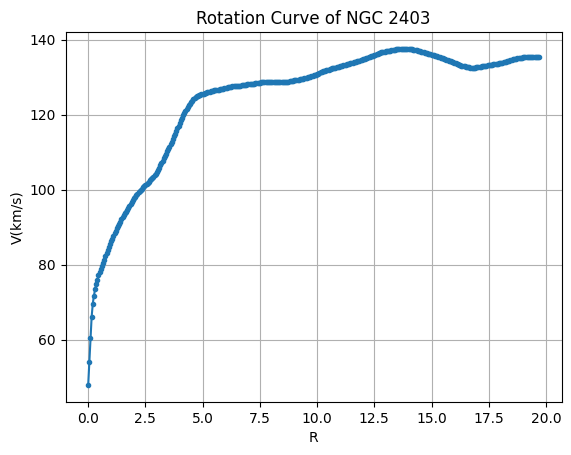

In [27]:
import matplotlib.pyplot as plt

# Assuming 'data' is already defined and has a column 'R' for the index
data.set_index('R').plot(style='.-', legend=False)

# Add title and axis labels
plt.title('Rotation Curve of NGC 2403')
plt.xlabel('R')
plt.ylabel('V(km/s)')

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.show()

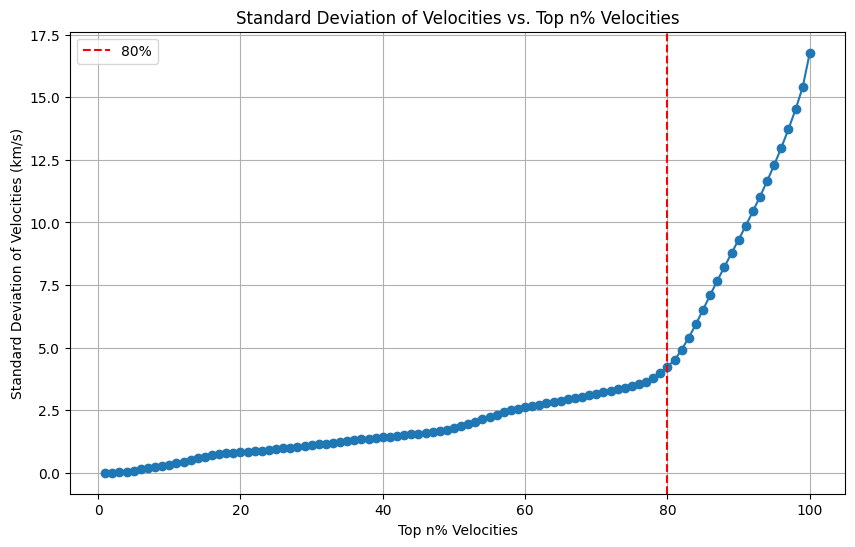

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'data' is already defined and has columns 'R' and 'V'
# Sort the data by the velocity column 'V'
sorted_data = data.sort_values(by='V', ascending=False)

# Define the range of percentages to consider
percentages = np.arange(1, 101)  # From 1% to 100%

# Calculate the standard deviation for each percentage
std_devs = []
for p in percentages:
    threshold_index = int(len(sorted_data) * (p / 100))
    top_percent = sorted_data.head(threshold_index)
    std_devs.append(top_percent['V'].std())

# Plot the standard deviation against the percentages
plt.figure(figsize=(10, 6))
plt.plot(percentages, std_devs, marker='o', linestyle='-')
plt.title('Standard Deviation of Velocities vs. Top n% Velocities')
plt.axvline(x=80, color='r', linestyle='--', label='80%')
plt.xlabel('Top n% Velocities')
plt.ylabel('Standard Deviation of Velocities (km/s)')
plt.legend()
plt.grid(True)
plt.show()

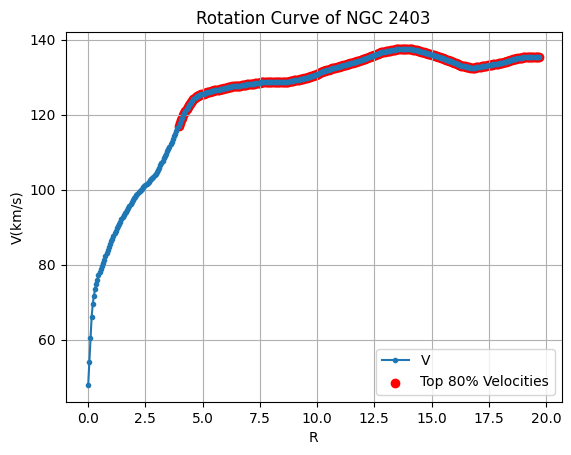

In [81]:
import matplotlib.pyplot as plt

# Assuming 'data' is already defined and has columns 'R' and 'V'
# Sort the data by the velocity column 'V'
sorted_data = data.sort_values(by='V', ascending=False)

n= 0.8
# Calculate the threshold for the top 30%
threshold_index = int(len(sorted_data) * n)

# Get the top 30% velocities
top_30_percent = sorted_data.head(threshold_index)

# Plot the data
data.set_index('R').plot(style='.-', legend=False)

# Highlight the top 30% velocities
plt.scatter(top_30_percent['R'], top_30_percent['V'], color='red', label=f'Top {int(n*100)}% Velocities')

# Add title and axis labels
plt.title('Rotation Curve of NGC 2403')
plt.xlabel('R')
plt.ylabel('V(km/s)')

# Add grid for better readability
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

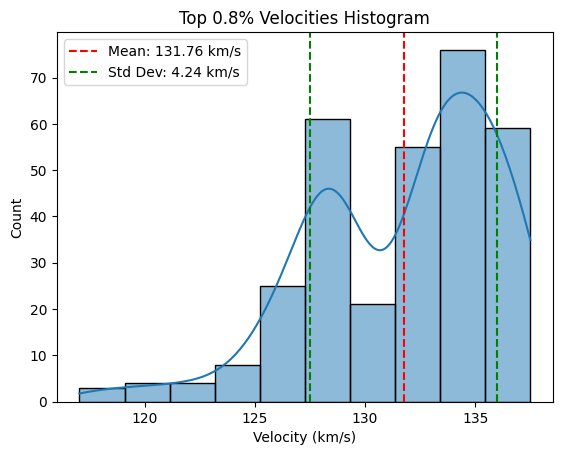

Mean velocity of top 80.0%: 131.76 km/s
Standard deviation of top 80.0%: 4.24 km/s


In [82]:
# Make a histogram with top n% velocities
import seaborn as sns
import matplotlib.pyplot as plt

def plot_top_n_percent_velocities(data, n):
    # Sort the data by the velocity column 'V'
    sorted_data = data.sort_values(by='V', ascending=False)

    # Calculate the threshold for the top n%
    threshold_index = int(len(sorted_data) * (n))

    # Get the top n% velocities
    top_n_percent = sorted_data.head(threshold_index)

    # Plot a histogram of the top n% velocities
    sns.histplot(top_n_percent['V'], kde=True, bins=10)

    # Draw mean and std lines
    mean_top = top_n_percent['V'].mean()
    std_top = top_n_percent['V'].std()

    plt.axvline(mean_top, color='r', linestyle='--', label=f'Mean: {mean_top:.2f} km/s')
    plt.axvline(mean_top + std_top, color='g', linestyle='--', label=f'Std Dev: {std_top:.2f} km/s')
    plt.axvline(mean_top - std_top, color='g', linestyle='--')

    # Add title and labels
    plt.title(f'Top {n}% Velocities Histogram')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Count')

    plt.legend()
    plt.show()

    return mean_top, std_top

# Example usage  # You can change this value to any percentage you want
v_max, std_ = plot_top_n_percent_velocities(data, n)

print(f"Mean velocity of top {n*100}%: {v_max:.2f} km/s")
print(f"Standard deviation of top {n*100}%: {std_:.2f} km/s")

In [83]:
import math

def tully_fisher_sa(v_max, a=-9.95, b=3.15):
    """
    Calculate the absolute magnitude of an Sa galaxy using the Tully-Fisher relation.
    
    Parameters:
    - v_max (float): Maximum rotational velocity of the galaxy (in km/s)
    - a (float): Slope of the Tully-Fisher relation for Sa galaxies (default: -8.5)
    - b (float): Intercept of the Tully-Fisher relation for Sa galaxies (default: -5.5)
    
    Returns:
    - M (float): Absolute magnitude of the galaxy
    """
    # Calculate the absolute magnitude using the Tully-Fisher relation
    M = a * math.log10(v_max) + b
    return M

absolute_magnitude = tully_fisher_sa(v_max)
absolute_magnitude


-17.94181384860025

In [84]:
import numpy as np

# Convert surface brightness to flux (linear scale)
flux = 10 ** (-0.4 * non_nan_surface_brightness)

# Assuming pixel scale is in arcsec/pixel, define the scale
pixel_scale = 1  # Replace with your actual pixel scale in arcsec/pixel

# Calculate the area in arcsec^2 for each semi-major axis interval
area = np.pi * (non_nan_radii**2) * (pixel_scale**2)

# Calculate the differential flux (flux times area)
differential_flux = flux * np.gradient(area)

# Integrate the total flux
total_flux = np.sum(differential_flux)

# Calculate the integrated apparent magnitude
integrated_magnitude = -2.5 * np.log10(total_flux)

# Output the integrated apparent magnitude
print(f"Integrated Apparent Magnitude: {integrated_magnitude:.2f}")


Integrated Apparent Magnitude: 8.82


In [88]:
def calculate_distance(apparent_magnitude, absolute_magnitude):
    # Calculate the distance modulus (m - M)
    distance_modulus = apparent_magnitude - absolute_magnitude
    
    # Calculate the distance using the distance modulus formula
    distance_parsecs = 10 ** ((distance_modulus + 5) / 5)
    
    return distance_parsecs

distance = calculate_distance(integrated_magnitude, absolute_magnitude)
distance/1e6 #megaparsecs


np.float64(2.2471398308857173)

In [140]:
scale_pixel = 0.79  # Example value in arcsec/pixel (replace with your value)

# Conversion from pixels to parsecs
re_arcsec = r_e * scale_pixel  # Convert to arcseconds
re_pc = re_arcsec * (distance / 206265)  # Convert to parsecs

# Output the result
print(f"Effective radius (r_e) in parsecs: {re_pc:.2f} pc")


Effective radius (r_e) in parsecs: 2751.76 pc
